In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

from scipy.linalg import det, inv, cho_solve

%matplotlib inline

# Problem 1: Gaussian Process

Assume data generating process is known as $f(x) = h(x)^{\top}$, $\beta \sim \mathcal{N}(0, \tau^2I_d)$, therefore $\tau$ is known and doesn't need to be learned (e.g. via MLE)?

In [2]:
from os import O_NDELAY
class GaussianProcess():
  """
  Define a Gaussian Process (GP) model
  """
  def __init__(self, gamma, tau_sq, sigma_sq):
    """
    GP Class Initializer
    Input:
      gamma: correlation length parameter in kernel formula
      tau_sq: process variance tau^2
      sigma_sq: variance of noise sigma^2
    """
    self.gamma = gamma
    self.tau_sq = tau_sq
    self.sigma_sq = sigma_sq

  def gaussian_kernel(self, X1, X2, gamma):
    """
    Constructs entire correlation matrix where each entry is K(x_i, x_j) with kernel function K
    """
    K = np.zeros((X1.shape[0], X2.shape[0]))
    for i in range(X1.shape[0]):
      K[i,:] = np.exp(-np.sum(gamma*(X1[i,:]-X2)**2, axis=1))     
    return K
    
  def neg_likelihood(self, gamma):
    """
    Negative likelihood function L(y | mu, tau^2, gamma)
    """
    pass

  def fit(self, X):
    """
    Fit Gaussian Process model (interpolative memorization)
    """
    self.X = X
    self.n = self.X.shape[0]
    self.K = self.gaussian_kernel(self.X, self.X, self.gamma)
    self.y = np.random.multivariate_normal(np.zeros(self.n), self.tau_sq*self.K) + np.random.multivariate_normal(np.zeros(self.n), self.sigma_sq*np.eye(self.n))    # y assumed to be of this form
    self.mu = 0    # defined to be 0 in problem setup
    
  def predict(self, X_test):
    """
    Make predictions with GP model --> (interpolative memorization...)
    """
    n = self.X.shape[0]
    one = np.ones((n, 1))
    I = np.eye(n)

    self.X_test = X_test
 
    inv_K = inv(self.K)    # inverse of correlation matrix K
    k = self.gaussian_kernel(self.X, self.X_test, self.gamma)    # correlation matrix between test and train data

    # Mean prediction
    mean = self.mu + (self.tau_sq * k.T) @ inv(self.tau_sq * self.K + self.sigma_sq * I) @ (self.y - self.mu * O_NDELAY) 
    
    # Variance prediction
    var = self.tau_sq*(1 - np.diag(k.T @ inv(self.tau_sq * self.K + self.sigma_sq * I) * self.tau_sq @ k))

    return mean.flatten(), var.flatten()

In [3]:
# Generate data
X = np.linspace(0.0, 1, 10).reshape(-1,1)
X_test = np.linspace(0.0, 1, 100).reshape(-1,1)    # queries

In [4]:
# GP model training
GP_model = GaussianProcess(gamma = 3, tau_sq = 2, sigma_sq = 0.5)
GP_model.fit(X)

# GP model predicting
y_pred, y_pred_SSqr = GP_model.predict(X_test)

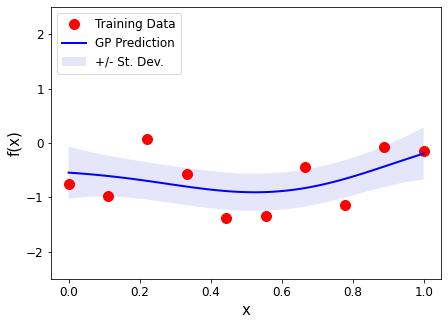

In [5]:
# Plot with true data points and posterior mean +/- standard deviation
fig, ax = plt.subplots(figsize=(7,5))

ax.plot(X, GP_model.y, 'ro', markerfacecolor='r', markersize=10, label='Training Data')
ax.plot(X_test, y_pred, 'b-', lw=2, label='GP Prediction')
ax.fill_between(X_test.flatten(), y_pred-np.sqrt(y_pred_SSqr), 
                y_pred+np.sqrt(y_pred_SSqr),
                facecolor='lavender',label='+/- St. Dev.')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-2.5,2.5]);
ax.legend(loc="upper left", prop={'size': 12});

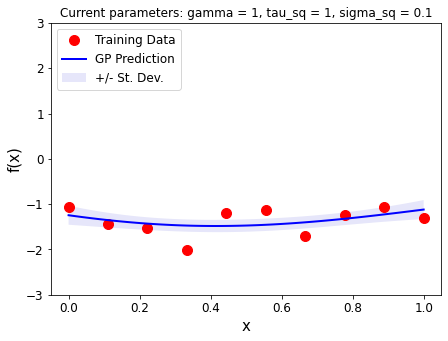

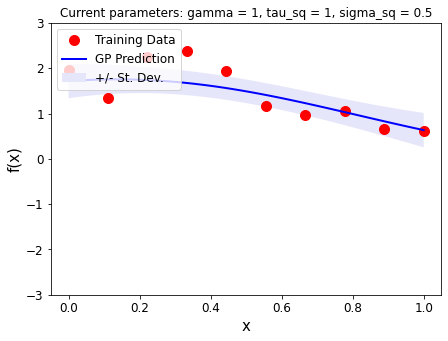

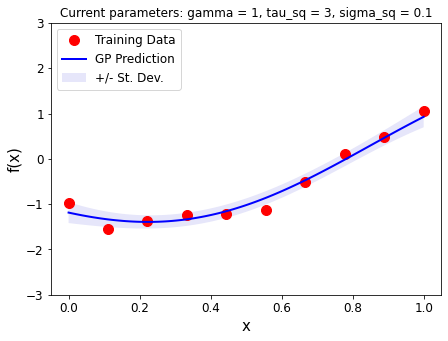

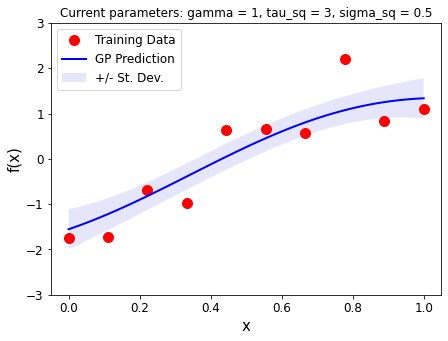

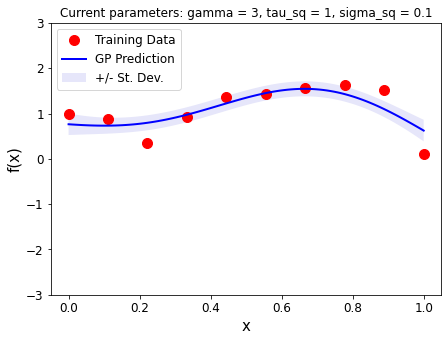

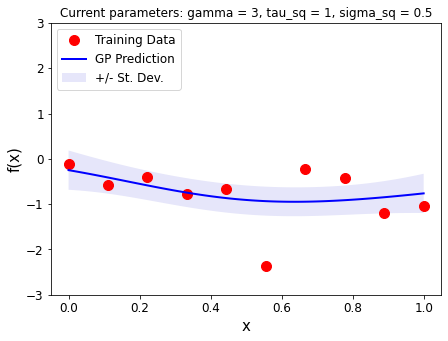

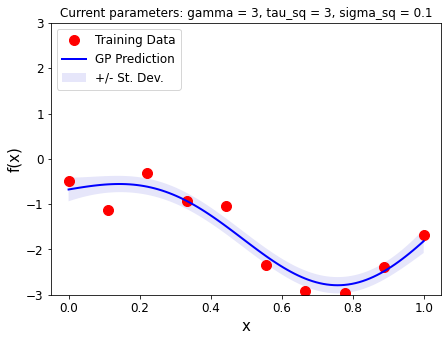

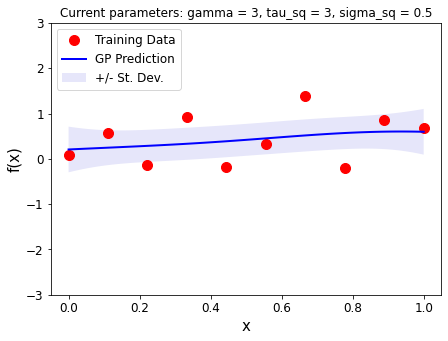

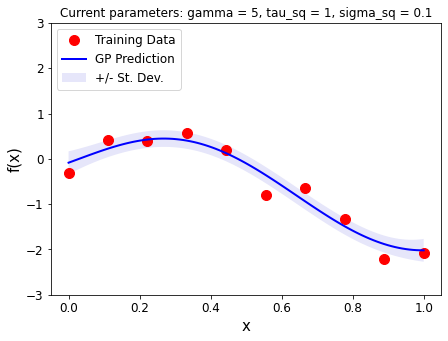

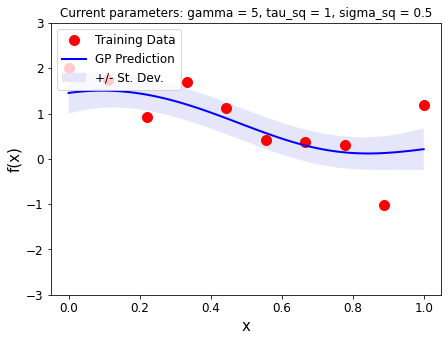

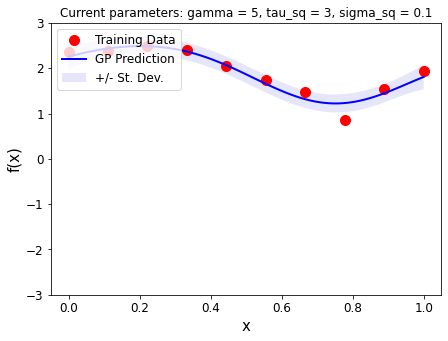

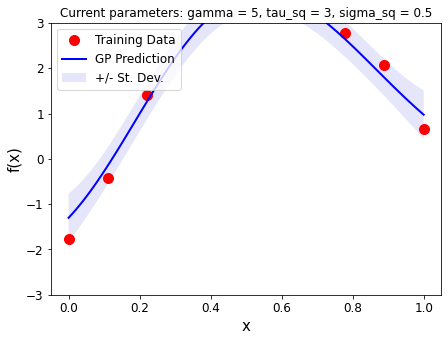

In [6]:
gammas = [1, 3, 5]
taus = [1, 3]
sigmas = [0.1, 0.5]

for gamma in gammas:
  for tau_sq in taus:
    for sigma_sq in sigmas:
      # GP model training
      GP_model = GaussianProcess(gamma, tau_sq, sigma_sq)
      GP_model.fit(X)

      # GP model predicting
      y_pred, y_pred_SSqr = GP_model.predict(X_test)

      # Plot with true data points and posterior mean +/- standard deviation
      fig, ax = plt.subplots(figsize=(7,5))

      ax.plot(X, GP_model.y, 'ro', markerfacecolor='r', markersize=10, label='Training Data')
      ax.plot(X_test, y_pred, 'b-', lw=2, label='GP Prediction')
      ax.fill_between(X_test.flatten(), y_pred-np.sqrt(y_pred_SSqr), 
                      y_pred+np.sqrt(y_pred_SSqr),
                      facecolor='lavender',label='+/- St. Dev.')
      ax.tick_params(axis='both', which='major', labelsize=12)
      ax.set_title("Current parameters: gamma = {}, tau_sq = {}, sigma_sq = {}".format(gamma, tau_sq, sigma_sq))
      ax.set_xlabel('x', fontsize=15)
      ax.set_ylabel('f(x)', fontsize=15)
      ax.set_ylim([-3, 3]);
      ax.legend(loc="upper left", prop={'size': 12});

# Problem 2: Support Vector Machine

In [7]:
def plot3D(name, X, Y, Yhat = None):
  x1 = X[:, 0]
  x2 = X[:, 1]

  fig = plt.figure()
  ax = fig.gca(projection = '3d')
  
  ax.scatter(x1, x2, Y, c = 'blue')
  
  try:
    Yhat = np.array(Yhat)
    ax.scatter(x1, x2, Yhat, c = 'red')
  except:
    print('error')

  ax.set_zlabel('y')
  ax.set_ylabel('x2')
  ax.set_xlabel('x1')
  plt.show()

In [8]:
class KernelSVM(object):
  def __init__(self, gamma, lamda):
    self.lamda = lamda
    self.gamma = gamma
    self.alpha = None

  def gaussian_kernel(self, x1, x2):
    return np.exp(-self.gamma * np.sum((x1 - x2) * (x1 - x2)))

  def train(self, X, Y, name):
    N = len(Y)
    self.N = N
    self.X = X
    self.Y = Y

    K = np.zeros((N, N))
    Y_dot = np.zeros((N, N))
    for i in range(N):
      for j in range(N):
        K[i, j] = self.gaussian_kernel(X[i], X[j])
        Y_dot[i, j] = Y[i] * Y[j]

    self.alpha = np.zeros((N))
    flag = 0
    while True:
      i = np.random.randint(0, N)    # choose a random index i for which to optimize alpha_i
      tmp = 2 * self.lamda
      for j in range(N):
        if j != i:
          tmp -= self.alpha[j] * Y_dot[i, j] * K[i, j]
      tmp /= K[i, j]
      tmp = max(tmp, 0)
      tmp = min(tmp, 1)

      if (np.abs(self.alpha[i] - tmp) < 1e-6):    # "not enough change made on i we've already visited"
        flag += 1
      else:
        flag = 0

      self.alpha[i] = tmp    # store alpha_i value
      if flag > 50:
        break
    
    Y_hat = np.sign(np.dot(K, Y * self.alpha))
    plot3D(name, X, Y, Y_hat)
    training_accuracy = np.sum(Y == Y_hat) / N
    print("Current training accuracy is {}".format(training_accuracy))
    return training_accuracy

  def test(self, X, Y, name):
    # if self.alpha == None:
    #     print("Error, please train the model first")
    #     return
    N = len(Y)
    K = np.zeros((N, self.N))
    for i in range(N):
      for j in range(self.N):
        K[i, j] = self.gaussian_kernel(X[i], self.X[j])
    Y_hat = np.sign(np.dot(K, self.Y * self.alpha))
    plot3D(name, X, Y, Y_hat)
    testing_acc = np.sum(Y == Y_hat) / N
    print("Current testing accuracy is {}".format(testing_acc))
    return testing_acc

In [9]:
# Create training data
X = np.random.uniform(size = (1000, 2))
Xsquare = X * X - 0.5
Y = np.sign(np.sum(Xsquare, axis = 1) + np.random.normal(scale = 0.1, size = (1000)))

# Create testing data
Xtest = np.random.uniform(size = (1000, 2))
Xtestsquare = Xtest * Xtest - 0.5
Ytest = np.sign(np.sum(Xtestsquare, axis = 1) + np.random.normal(scale = 0.1, size = (1000))) # y = sign(x1^2 + x2^2 - 1)

<ipython-input-7-52183b34d998>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection = '3d')


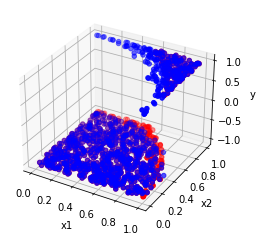

Current training accuracy is 0.897


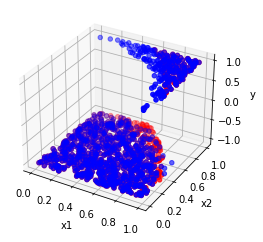

Current testing accuracy is 0.899


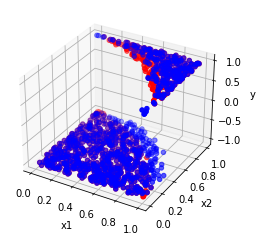

Current training accuracy is 0.907


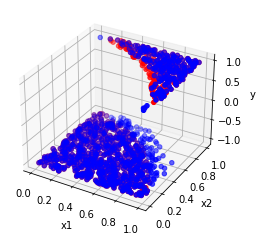

Current testing accuracy is 0.909


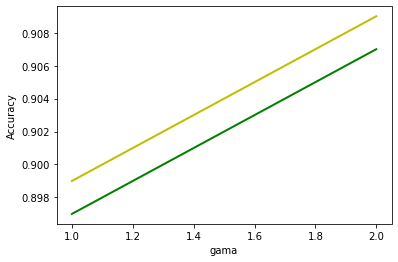

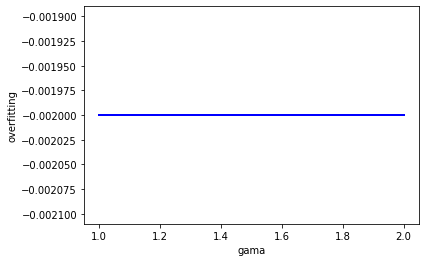

In [10]:
#fix lambda and change gama
lamda = 0.01
gama = []
training_acc = []
testing_acc = []
overfitting = [] 
for i in range(1, 3):    # try different values of gamma!
    model = KernelSVM(i, lamda)
    tmptrain = model.train(X, Y, "gamatrain_{}.jpg".format(i))
    tmptest = model.test(Xtest, Ytest, "gamatest_{}.jpg".format(i))
    gama.append(i)
    training_acc.append(tmptrain)
    testing_acc.append(tmptest)
    overfitting.append(tmptrain - tmptest)

plt.figure('model')
plt.plot(gama, training_acc, 'g', lw = 2)
plt.plot(gama, testing_acc, 'y', lw = 2)
plt.xlabel('gama')
plt.ylabel('Accuracy')
plt.savefig('gama_acc.png')
plt.show()

plt.figure('model')
plt.plot(gama, overfitting, 'b', lw = 2)
plt.xlabel('gama')
plt.ylabel('overfitting')
plt.savefig('gama_overfittingacc.png')
plt.show()

<ipython-input-7-52183b34d998>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection = '3d')


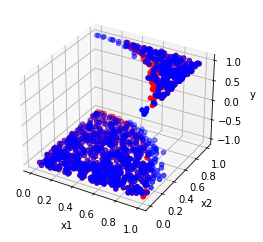

Current training accuracy is 0.922


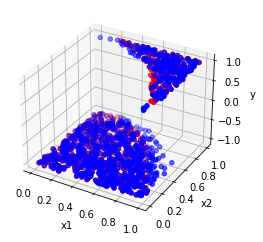

Current testing accuracy is 0.932


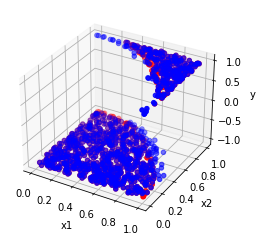

Current training accuracy is 0.939


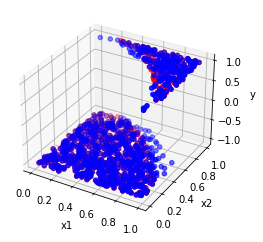

Current testing accuracy is 0.941


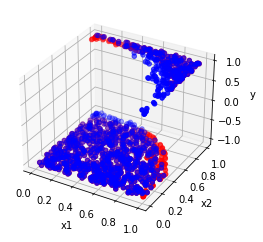

Current training accuracy is 0.896


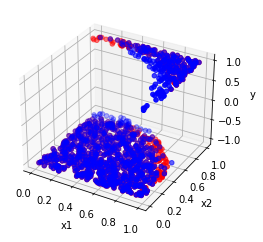

Current testing accuracy is 0.895


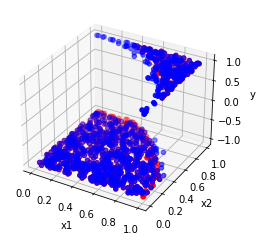

Current training accuracy is 0.932


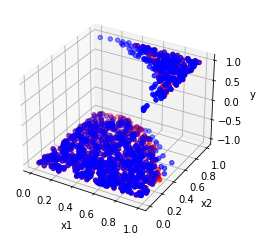

Current testing accuracy is 0.934


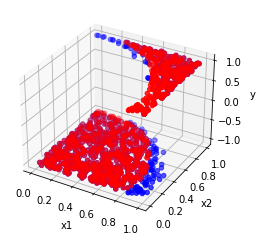

Current training accuracy is 0.909


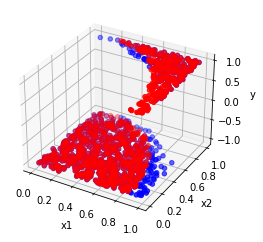

Current testing accuracy is 0.906


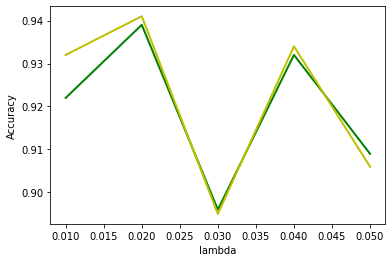

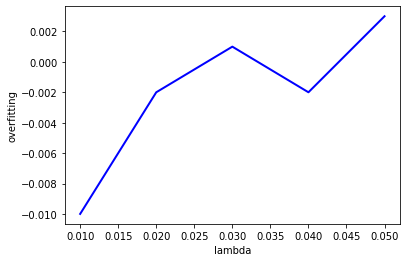

In [11]:
#fix gama and change Lambda
gama = 3
lamda = []
training_acc = []
testing_acc = []
overfitting = [] 
for i in range(1, 6):
    model = KernelSVM(gama, 0.01 * i)
    tmptrain = model.train(X, Y, "lamdatrain_{}.jpg".format(i))
    tmptest = model.test(Xtest, Ytest, "lamdatest_{}.jpg".format(i))
    lamda.append(i * 0.01)
    training_acc.append(tmptrain)
    testing_acc.append(tmptest)
    overfitting.append(tmptrain - tmptest)

plt.figure('model')
plt.plot(lamda, training_acc, 'g', lw = 2)
plt.plot(lamda, testing_acc, 'y', lw = 2)
plt.xlabel('lambda')
plt.ylabel('Accuracy')
plt.savefig('lamda_acc.png')
plt.show()

plt.figure('model')
plt.plot(lamda, overfitting, 'b', lw = 2)
plt.xlabel('lambda')
plt.ylabel('overfitting')
plt.savefig('lamda_overfittingacc.png')
plt.show()

0.9925060067407452


<ipython-input-7-52183b34d998>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection = '3d')


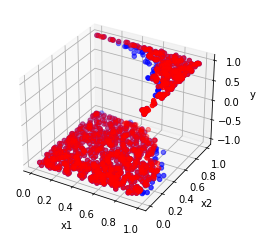

Current testing accuracy is 0.95


In [12]:
# Import homework 2 code for XGBoost to compare
from scipy import linalg
from sklearn.metrics import roc_auc_score

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# Indices of data points in the current region
def in_region(data, region):
  '''
  data: an array of size (n, 2)
  region: an array of size (1, 2**2)
  returns array
  '''
  return np.where((region[0] <= data[:, 0]) & (data[:, 0] < region[1]) & (region[2] <= data[:, 1]) & (data[:, 1] < region[3]))

def decision_tree(x, y):
  all_preds = np.zeros_like(y)
  shat = y
  for p in range(1):
    preds = np.zeros_like(y)
    regions = np.array([0, 1, 0, 1]).reshape((1, 4))
    for num in range(1):
      new_regions = np.zeros((1, 4))
      region_to_delete = -1
      for i, M in enumerate(regions):
        x_in_region = x[in_region(x, M)]
        min_loss = np.infty
        losses = np.array((2, 0))
        for j in [0, 1]:
          # We don't want to consider the "end points", i.e. we shouldn't cut off at a leftmost or rightmost point, we would then be creating an empty region...
          possible_cutoffs = np.sort(x_in_region[:, j])[1:-1]
          for xij in possible_cutoffs:
            added_loss = 0
            # Define cut/new region to make
            if (j == 0):
              new_region_1 = np.array([M[0], xij, M[2], M[3]]).reshape((4, ))
              new_region_2 = np.array([xij, M[1], M[2], M[3]]).reshape((4, ))
            if (j == 1):
              new_region_1 = np.array([M[0], M[1], xij, M[3]]).reshape((4, ))
              new_region_2 = np.array([M[0], M[1], M[2], xij]).reshape((4, ))  
            
            for new_region in [new_region_1, new_region_2]:
              new_idx = in_region(x, new_region)
              phat = np.mean(y[new_idx])
              added_loss += np.sum((shat[new_idx] - phat)**2)

            if added_loss < min_loss:   
              #print("this is the best cutoff SO FAR")
              min_loss = added_loss

              good_region_1 = new_region_1
              good_region_2 = new_region_2

              new_idx_1 = in_region(x, good_region_1)
              new_idx_2 = in_region(x, good_region_2)

              phat_1 = np.mean(y[new_idx_1])
              phat_2 = np.mean(y[new_idx_2])

          preds[in_region(x, good_region_1)] = phat_1
          preds[in_region(x, good_region_2)] = phat_2

          new_regions = np.vstack([new_regions[:-2], good_region_1, good_region_2])
          region_to_delete = i
            
      # Change regions here
      regions = np.delete(regions, region_to_delete, axis=0)
      regions = np.vstack([regions, new_regions], )

  return preds


def xg_wu(x, y, num):
  preds = decision_tree(x, y)
  resid = y - sigmoid(preds)
  for i in range(num):
    preds += decision_tree(x, resid)
    #print(preds[:10])
    if (i == num-1):
      print(roc_auc_score(y, sigmoid(preds)))
    resid = y - sigmoid(preds)
  return sigmoid(preds)


# Must change Y to be 0/1 instead of +1/-1 for XGBoost
Y = np.array([0. if yi == -1. else 1. for yi in Y])

good_preds = xg_wu(X, Y, 100)
preds_list = [1. if p >= 0.5 else -1. for p in good_preds]

# Change Y back for plotting purposes
Y = np.array([-1. if yi == 0. else 1. for yi in Y])
#preds_list = np.array([-1. if pred == 0. else 1. for pred in preds_list])

plot3D("XGBoost Classification", X, Y, Yhat = preds_list)
print("Current testing accuracy is {}".format(round(np.mean(preds_list == Y), 4)))